In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import geometry
import shapely.speedups
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.cluster import KMeans
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of input data
## Generates a DataFrame of PT stops with mean weighted distances to population cells
## Needs all PT nodes

In [2]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network')

In [4]:
# Map nodes to zones
if 'FID' not in sm.nodes.columns:
    shapely.speedups.enable()
    sm.nodes['FID'] = np.nan
    sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    sm.to_json(model_path + 'de_pt_network',
          only_attributes=['zones', 'links', 'nodes',
                           'pt_routes', 'agencies',
                           'pt_route_types'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [00:31<00:00,  1.13it/s]


In [5]:
bus = stepmodel.read_json(model_path + 'de_pt_network_bus')

In [6]:
# Map bus nodes to zones
if 'FID' not in bus.nodes.columns:
    shapely.speedups.enable()
    bus.nodes['FID'] = np.nan
    bus.nodes = gpd.GeoDataFrame(bus.nodes, crs=sm.epsg)
    for _, zone in tqdm(bus.zones.iterrows(), total=bus.zones.shape[0]):
        bus.nodes.loc[bus.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    bus.to_json(model_path + 'de_pt_network_bus',
          only_attributes=['zones', 'links', 'nodes',
                           'pt_route_types', 'agencies',
                           'pt_routes'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [07:02<00:00, 11.74s/it]


In [7]:
# Merge
sm.nodes = sm.nodes.append(bus.nodes)

## Use census data
The important question for mode choice problems: How long/inconvenient is it from home to the next PT stop? </br>
Approach: Build population densities from census data and calculate the mean weighted distance to the next PT stop.

In [8]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)

In [9]:
print(pop.shape)
pop.head(2)

(3177723, 4)


,Einwohner,NUTS_ID,FID,geometry
0,8,DE27E,DE27E,POINT (10.21212 47.31574)
1,7,DE27E,DE27E,POINT (10.26631 47.31562)


In [10]:
pop_r = pop

In [11]:
# Restrict to a geometric hull
#zones = gpd.read_file("../input/network/zones/NUTS_RG_01M_2016_4326.geojson")
#zones = zones[zones["CNTR_CODE"] == "DE"]
#zones = zones[zones["id"].str.startswith("DE73")] # only Kassel and surrounding
#hull = zones["geometry"].values[0].buffer(1e-3) # index 0 for Germany; 12 for Berlin
# Restrict to the geometric hull if the latter is not Germany
#pop_r = pop.loc[pop['geometry'].apply(lambda p: p.within(hull))]
#print(pop_r.shape)

In [12]:
# Map to zones
if 'FID' not in pop_r.columns:
    shapely.speedups.enable()
    pop_r['FID'] = np.nan
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        pop_r.loc[pop_r['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    pop_r.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

100%|██████████████████████████████████████████████████████████████████████████████| 467/467 [2:04:04<00:00, 15.94s/it]


In [13]:
pop_r.loc[pop_r['FID'].isna()]

,Einwohner,NUTS_ID,FID,geometry
3816,5,None,None,POINT (9.91838 47.53103)
3962,13,None,None,POINT (9.73521 47.53524)
3994,13,None,None,POINT (9.73654 47.53615)
5554,19,None,None,POINT (9.74703 47.56137)
7497,5,None,None,POINT (8.08700 47.55841)
...,...,...,...,...
3177060,3,None,None,POINT (8.69160 54.90699)
3177077,3,None,None,POINT (8.69001 54.90787)
3177148,9,None,None,POINT (8.67119 54.91127)
3177149,3,None,None,POINT (8.67275 54.91129)


<AxesSubplot:>

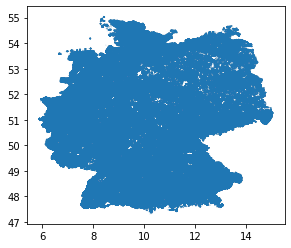

In [14]:
# Visualise
#zones_plot = sm.plot('zones', alpha=0.1, figsize=[16, 9], color='green')
pop_r.plot(markersize=list(pop_r['Einwohner']/150), alpha=0.2)#, ax=zones_plot)

### Apply K-Means to find weighted distances of PT stops

In [15]:
sm.nodes.shape

(417977, 4)

In [16]:
# Settings:
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
pop_col = 'population'
max_iter_per_group = 10

In [17]:
def weighted_dist(zone):
    nuts_id = zone['FID'].unique()[0]
    # Get the population points
    pop_p = pop_r.loc[pop_r['FID']==nuts_id]
    # Count the number of PT stops in the zone and make it the number of clusters
    n_clusters = len(zone.index)
    if n_clusters > 0:
        # Prepare sample
        X = np.array([[p.x, p.y] for p in list(pop_p['geometry'])])
        # Prepare initial starting points
        nodes_coords = np.array([[p.x, p.y] for p in list(zone['geometry'])])
        # Apply weighted K-Means
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=0,
                        init=nodes_coords,
                        max_iter=max_iter_per_group)
        kmeans.fit(X, sample_weight=np.array(list(pop_p['Einwohner'])))
        # Create results DataFrame
        zone[cent_col] = [geometry.Point(c[0], c[1]) for c in kmeans.cluster_centers_]
        # Add population to calculate the mean weighted distance for each zone later
        #pop_p['label'] = list(kmeans.labels_)
        #zone[pop_col] = list(pop_p.groupby('label').agg({'Einwohner': 'sum'})['Einwohner'])
        #zone[pop_col] = sm.zones.loc[nuts_id, 'population']
        # Calculate distance between centroid and PT node
        zone[dist_col] = [geodesic(kmeans.cluster_centers_[i], nodes_coords[i]).km * 1000
                          for i in range(n_clusters)]
        # Add mean weighted distance
        zone[mean_dist_col] = zone[dist_col].mean()
        return zone
    else:
        return

In [18]:
# Generate clusters for every route type
tqdm.pandas()
clusters = sm.nodes.groupby(['route_type', 'FID']).progress_apply(weighted_dist)

100%|██████████████████████████████████████████████████████████████████████████████| 1379/1379 [24:26<00:00,  1.06s/it]


In [19]:
clusters.sample(4)

,FID,geometry,route_type,stop_name,cluster_center,weighted_dist,mean_weighted_dist
index,,,,,,,
bus_n_27570,DE948,POINT (8.07261 52.99701),bus,"Barkentange, Trafo, Mast 1",POINT (8.068083444720617 52.99724778031489),501.415692,5613.773657
bus_n_216323,DE939,POINT (9.25877 53.78105),bus,"Oederquart, Freiburger Weg",POINT (9.253938096934 53.78142290952833),536.432656,4312.640242
bus_n_171954,DE94C,POINT (7.57219 53.09209),bus,"Burlage, Landesstr. Nr. 4, Mast 1",POINT (7.559265163507112 53.09799823748125),1571.426215,3047.127481
bus_n_201756,DE271,POINT (10.92797 48.39986),bus,Endorferstraße,POINT (10.83386863279725 48.37919051784885),10651.545037,2019.698551


route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

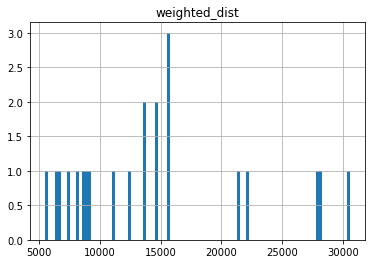

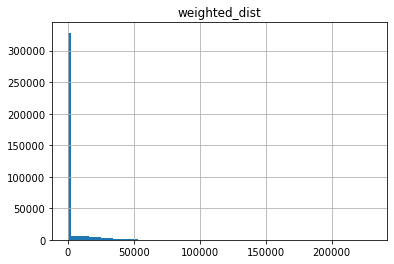

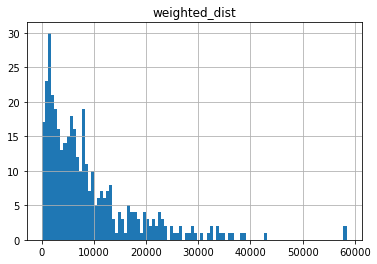

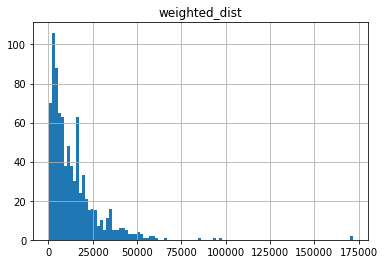

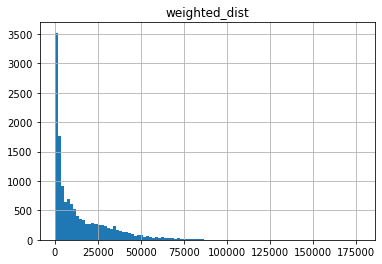

In [20]:
clusters.groupby('route_type').hist(column=dist_col, bins=100)

In [21]:
# Save the population centroids
clusters.to_csv('../input/spatial_census_refined_FID.csv')

In [22]:
# Correct population numbers in model zones
def weighted_pop(g):
    pop_sum_census = pop_r.loc[pop_r['NUTS_ID']==g['NUTS_ID'].unique()[0], 'Einwohner'].sum()
    for zone in g.index:
        pop_census = pop_r.loc[pop_r['FID']==g.loc[zone, 'FID'], 'Einwohner'].sum()
        g.loc[zone, 'population'] = int(g.loc[zone, 'population'] * (pop_census / pop_sum_census))
    return g
sm.zones.loc[sm.zones['NUTS_ID']!=sm.zones['FID'], 'population'] = \
    sm.zones.loc[sm.zones['NUTS_ID']!=sm.zones['FID']].groupby('NUTS_ID').apply(weighted_pop)

In [23]:
sm.zones.loc[sm.zones['NUTS_ID']!=sm.zones['FID']].head(4)

,CNTR_CODE,NUTS_NAME,LEVL_CODE,FID,NUTS_ID,population,area,urbanisation,lau_id,geometry
index,,,,,,,,,,
DE929_city,DE,Hannover,3,DE929_city,DE929,268224,204.300000,1.0,3241001,"POLYGON ((9.78861 52.37444, 9.78837 52.36954, ..."
DE80J_1,DE,Mecklenburgische Seenplatte 1,3,DE80J_1,DE80J,165293,2798.508584,3.0,13071,"POLYGON ((12.98671 54.00397, 13.01458 53.99296..."
DE80J_2,DE,Mecklenburgische Seenplatte 2,3,DE80J_2,DE80J,93836,2697.101416,3.0,13071,"POLYGON ((13.08455 53.20969, 13.07811 53.20102..."
DE80O_1,DE,Ludwigslust-Parchim 1,3,DE80O_1,DE80O,104552,2551.553354,3.0,13076,"POLYGON ((11.79735 53.77078, 11.80594 53.76725..."


In [24]:
# Save corrected zones
sm.to_json(model_path + 'de_zones',
      only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 27.77it/s]
